In [12]:
import sys
sys.path.append('/home/akshay/proj/ephys_analysis')
from myinit import *
import pandas as pd

import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm
from scipy import stats

import json

In [3]:
behav_df = pd.read_parquet(f'data/human-behavior-data_jan2025_processed.parquet')

# Plot behavioral performance

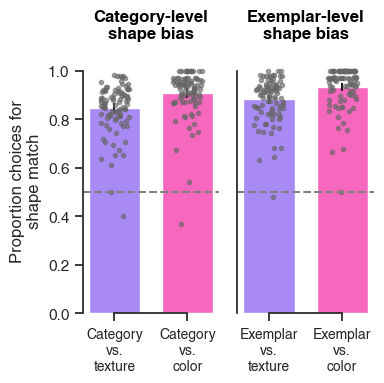

In [4]:
df = behav_df[behav_df.sample_duration == 500].copy().reset_index(drop=True)

colors = sns.husl_palette(h=0.6, n_colors=6)
colors = [colors[1], colors[2]]
fig, axes = plt.subplots(1,2,figsize=(4,4))

ax = axes[0]
b0 = sns.color_palette('colorblind')[0]
tasktypes = ['texcolvscateg',  'colorvscateg',]
labels = ['Category\nvs.\ntexture','Category\nvs.\ncolor',  ]
colshifts = np.linspace(.9, 1.1, len(tasktypes))
for ti, tasktype in enumerate(tasktypes):
    R = df[(df.tasktype == tasktype)].response

    ax.bar(ti, R.agg(np.nanmean), yerr=SE(df[(df.tasktype == tasktype)].groupby('subject_id').response.mean()),
           color = colors[ti], width=.7)
    
    for si, subj in enumerate(df.subject_id.unique()):
        R = df[(df.tasktype == tasktype) * (df.subject_id == subj)].response
        ax.plot(ti + np.random.rand()*0.4 - 0.2, 
                R.mean(), marker = '.', color = [.4,.4,.4], alpha=0.6,)
                
ax.axhline(0.5, color='gray', ls='--')
ax.set_title('Category-level\nshape bias')
ax.set_xticks(np.arange(len(tasktypes)), labels, fontsize=10)
ax.set_ylim(0,1.1)
ax.set_ylabel('Proportion choices for\nshape match')

ax = axes[1]
tasktypes =  ['texcolvsexemplar','colorvsexemplar']
labels = ['Exemplar\nvs.\ntexture', 'Exemplar\nvs.\ncolor', ]
colshifts = np.linspace(.9, 1.1, len(tasktypes))
for ti, tasktype in enumerate(tasktypes):
    R = df[(df.tasktype == tasktype)].response

    ax.bar(ti, R.agg(np.nanmean), yerr=SE(df[(df.tasktype == tasktype)].groupby('subject_id').response.mean()),
           color = colors[ti], width=.7)
    
    for si, subj in enumerate(df.subject_id.unique()):
        R = df[(df.tasktype == tasktype) * (df.subject_id == subj)].response
        ax.plot(ti + np.random.rand()*0.4 - 0.2, 
                R.mean(), marker = '.', color = [.4,.4,.4], alpha=0.6,)
                
ax.axhline(0.5, color='gray', ls='--')
ax.set_title('Exemplar-level\nshape bias')
ax.set_xticks(np.arange(len(tasktypes)), labels, fontsize=10)
ax.set_ylim(0,1.1)
ax.yaxis.set_visible(False)
# ax.set_ylabel('Proportion choices for exemplar match')

sns.despine(trim=True)
fig.tight_layout()
# fig.savefig('figures/behavior_2025-01/allsubjects_task-behavior_shapebias.pdf',bbox_inches='tight', transparent=True)

2 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


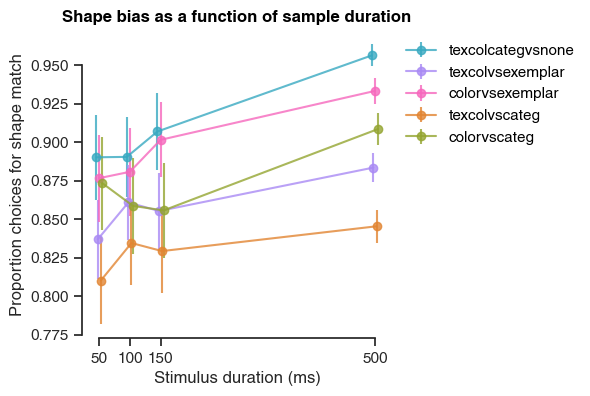

In [59]:
durations = [50, 100, 150, 500]
tasktypes = ['texcolcategvsnone', 'texcolvsexemplar','colorvsexemplar', 'texcolvscateg',  'colorvscateg',]
colors = sns.color_palette()
fig, ax = plt.subplots(figsize=(4,4))

xshifts = np.linspace(-5,5, len(tasktypes))

for ti, tasktype in enumerate(tasktypes):
    df = behav_df[behav_df.tasktype==tasktype]

    task_acc = df.groupby('sample_duration')['response'].mean().loc[durations]
    task_acc_sd = df.groupby('sample_duration')['response'].agg(SE).loc[durations]
    
    ax.errorbar(np.array(durations)+xshifts[ti], task_acc, yerr=task_acc_sd, color=colors[ti], ls='-', marker='o', label = tasktype, alpha=0.8)
# ax.plot([50, 500], [0.5, 0.5], ls='--', color=[.4, .4, .4])
ax.set_xticks(durations)
ax.set_title('Shape bias as a function of sample duration')
ax.set_xlabel('Stimulus duration (ms)')
ax.set_ylabel('Proportion choices for shape match')
ax.legend(frameon=False, bbox_to_anchor=[1.,1])
sns.despine(trim=True)
fig.savefig('figures/behavior_2025-01/human-behavior_shapebias-vs-duration.pdf',bbox_inches='tight', transparent=True)

# Stats

In [20]:
# Compare each condition to chance
df = behav_df[(behav_df.sample_duration == 500)*(behav_df.tasktype!='texcolcategvsnone')].copy().reset_index(drop=True)
df["tasktype"] = df["tasktype"].astype("category")
df["subject_id"] = df["subject_id"].astype("category")
df["sample_categ"] = df["sample_categ"].astype("category")
df["sample_texture"] = df["sample_texture"].astype("category")
df["sample_color"] = df["sample_color"].astype("category")

random_df = df.copy()
random_df['tasktype'] = 'random'  # Set tasktype to "random"
random_df['response'] = np.random.randint(0, 2, size=len(random_df))  # Randomly assign 0 or 1

# Combine the original DataFrame with the new "random" DataFrame
combined_df = pd.concat([df, random_df], ignore_index=True)

# Convert 'tasktype' to a categorical variable with "random" as the reference level
combined_df['tasktype'] = pd.Categorical(combined_df['tasktype'], categories=[
    'random',  # Reference level (comes first)
    'colorvscateg',
    'colorvsexemplar',
    'texcolvscateg',
    'texcolvsexemplar'
], ordered=False)

print('combined')
# Fit a generalized linear mixed model (GLMM) with a binomial link function
model = smf.mixedlm(
    "response ~ tasktype",  # Fixed effects: tasktype (comparison type)
    combined_df,
    groups=combined_df["subject_id"],  # Primary grouping variables.
    re_formula="1",  # Random intercept for subject_id
    vc_formula={
        "sample_categ": "0 + C(sample_categ)",  # Random intercepts for sample_categ
        "sample_object": "0 + C(sample_object)",  # Random intercepts for sample_object
        "sample_color": "0 + C(sample_color)"  # Random intercepts for sample_color
    }
).fit(method="lbfgs")

# Print model summary
print(model.summary())


combined

/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 812.077587
  warnings.warn(msg, ConvergenceWarning)
/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/akshay/miniconda3/envs/myenv/lib/python3.10/sit

Mixed Linear Model Regression Results
======================================================================
Model:                 MixedLM     Dependent Variable:     response   
No. Observations:      30280       Method:                 REML       
No. Groups:            91          Scale:                  0.1635     
Min. group size:       310         Log-Likelihood:         -16987.5769
Max. group size:       358         Converged:              No         
Mean group size:       332.7                                          
----------------------------------------------------------------------
                             Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.500    0.046 10.878 0.000  0.410  0.590
tasktype[T.colorvscateg]     0.405    0.008 49.235 0.000  0.388  0.421
tasktype[T.colorvsexemplar]  0.430    0.008 53.035 0.000  0.414  0.446
tasktype[T.texcolvscateg]    0.348    0.007 49.201 0.000  0.334  0.361
tasktype[T.texcolvsexemplar] 0.384    0.007 55.268 0.000  0.371  0.398
Group Var                    0.150                                    
sample_categ Var             0.003    0.002                           
sample_color Var             0.123                                    
sample_object Var            0.007    0.003                           
======================================================================

In [28]:
# Compare each condition to chance
df = behav_df[(behav_df.sample_duration == 500)*(behav_df.tasktype!='texcolcategvsnone')].copy().reset_index(drop=True)
df["tasktype"] = df["tasktype"].astype("category")
df["subject_id"] = df["subject_id"].astype("category")
df["sample_categ"] = df["sample_categ"].astype("category")
df["sample_texture"] = df["sample_texture"].astype("category")
df["sample_color"] = df["sample_color"].astype("category")

df['task_colorortexture'] = df['tasktype'].apply(lambda x: 'color' if 'color' in x else 'texture')

# Fit a generalized linear mixed model (GLMM) with a binomial link function
model = smf.mixedlm(
    "response ~ C(task_colorortexture, Treatment(reference='texture'))",  # Fixed effects: tasktype (comparison type)
    df,
    groups=df["subject_id"],  # Primary grouping variables.
    re_formula="1",  # Random intercept for subject_id
    vc_formula={
        "sample_categ": "0 + C(sample_categ)",  # Random intercepts for sample_categ
        "sample_object": "0 + C(sample_object)",  # Random intercepts for sample_object
        "sample_color": "0 + C(sample_color)"  # Random intercepts for sample_color
    }

).fit(method="lbfgs")

# Print model summary
print(model.summary())


/home/akshay/miniconda3/envs/myenv/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Mixed Linear Model Regression Results
=========================================================================================================
Model:                             MixedLM                 Dependent Variable:                 response  
No. Observations:                  15140                   Method:                             REML      
No. Groups:                        91                      Scale:                              0.0849    
Min. group size:                   155                     Log-Likelihood:                     -3467.9433
Max. group size:                   179                     Converged:                          Yes       
Mean group size:                   166.4                                                                 
---------------------------------------------------------------------------------------------------------
                                                                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                                       0.862    0.009 91.668 0.000  0.843  0.880
C(task_colorortexture, Treatment(reference='texture'))[T.color] 0.045    0.005  8.761 0.000  0.035  0.055
Group Var                                                       0.006    0.004                           
sample_categ Var                                                0.007    0.003                           
sample_color Var                                                0.001    0.001                           
sample_object Var                                               0.001    0.004                           
=========================================================================================================